# Sectoral Model
In this notebook a model for each sectors is created.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
from pathlib import Path
import re
import json
import seaborn as sns

from ProjectPackage.util import *
from ProjectPackage.DataProcessing import *
from ProjectPackage.Modeling import *
from ProjectPackage.PlotFunctions import *

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold

In [2]:
feature, target = load_dataframes()

In [3]:
target.head()

,date,year,month,ticker,firm,marketcap,Sector
0,2009-01-01,2009,1,ALYAG,ALTINYAĞ,1.077940e+04,enerji
1,2009-01-01,2009,1,AEFES,ANADOLU EFES,4.995000e+06,gida
2,2009-01-01,2009,1,BANVT,BANVİT,1.370000e+05,gida
3,2009-01-01,2009,1,CCOLA,COCA COLA İÇECEK,1.958655e+06,gida
4,2009-01-01,2009,1,ERSU,ERSU GIDA,1.116000e+04,gida


In [4]:
data_dict = load_data_sector(
    n_months=6, # Number of months ahead to be predicted
    pct_change=True, # Compute percentage change
    drop_corr_features=True, # Drop highly correlated features
    encoding_method='numeric', # Encoding method for tickers and sectors ("numeric", "one-hot", or None)
    drop=False, # Drop one of the one hot encoding columns to avoid multicollinearity
    year_range=(2008, 2017) # Range of years to be included (inclusive)
)

In [5]:
data_dict.keys()

dict_keys(['tas', 'imalat', 'gida', 'gayrimenkul', 'finans', 'enerji', 'camseramik', 'Bilisim', 'tekstil', 'menkul', 'turizm', 'kimya', 'ambalaj', 'anametal', 'holding'])

In [7]:
data_dict['imalat'].keys()

dict_keys(['X', 'y', 'data'])

## Modeling Percentage change

### Linear regression
Using the old sectoral division

In [7]:
all_scores = run_sector_pct_model(
    LinearRegression,
    model_params={},
    model_fit_params={},
    month_range=range(1, 7),
    drop_corr_features=True,
    encoding_method='one-hot',
    drop=True,
    year_range=(2008, 2017),
)

C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, dummy_cols.columns] = dummy_cols.copy()
C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, dummy_cols.columns] = dummy_cols.copy()
C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting 

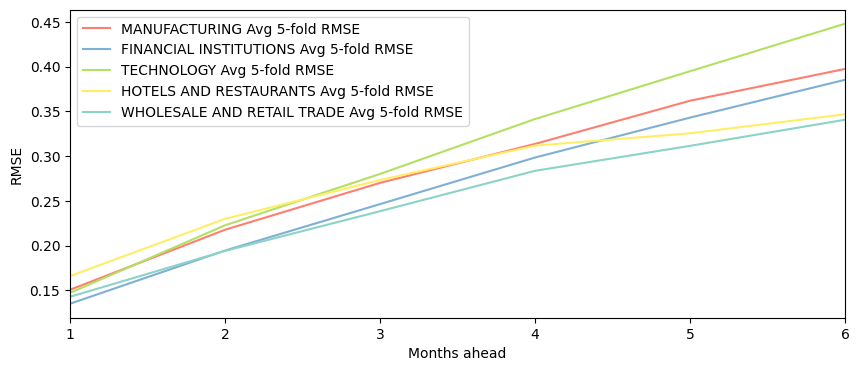

In [9]:
ax = plot_metric_by_months_sector(all_scores, 'RMSE')

In [10]:
# save_scores(all_scores, 'model_scores/LR_pct_sector.json')

### Linear regression
Using the new sectoral division

In [5]:
all_scores = run_sector_pct_model(
    LinearRegression,
    model_params={},
    model_fit_params={},
    month_range=range(1, 7),
    drop_corr_features=True,
    encoding_method='one-hot',
    drop=True,
    year_range=(2008, 2017),
)

C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, dummy_cols.columns] = dummy_cols.copy()
C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, dummy_cols.columns] = dummy_cols.copy()
C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting 

In [4]:
def plot_metric_by_months_sector(all_scores, metric='MAE', ax=None, linestyle='-', color=None, alpha=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
       
    x = list(all_scores.keys())
    sectors = all_scores[x[0]].keys()
    
    x = list(map(int, x))
    
#     colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#ffee65", "#8bd3c7"]

    for sector in sectors:
        score_arr = []
        std_arr = []
        
        for n_months in all_scores.keys():
            model_scores = all_scores[n_months][sector]
            score_arr.append(np.mean(model_scores[metric]))
            std_arr.append(np.std(model_scores[metric]))

        score_arr = np.array(score_arr)
        std_arr = np.array(std_arr)

        low = score_arr - 2*std_arr
        upp = score_arr + 2*std_arr

        ax.plot(x, score_arr, label=f'{sector}', linestyle=linestyle, color=color, alpha=alpha)
#         ax.fill_between(x=x, y1=low, y2=upp, alpha=0.2, color=color)
        
    ax.set_xlabel('Months ahead')
    ax.set_ylabel(metric)
    ax.set_xlim(x[0], x[-1])
    ax.set_title(f'Avg 5-fold {metric} by predicted months ahead')
    ax.legend(ncols=2)
    
    return ax

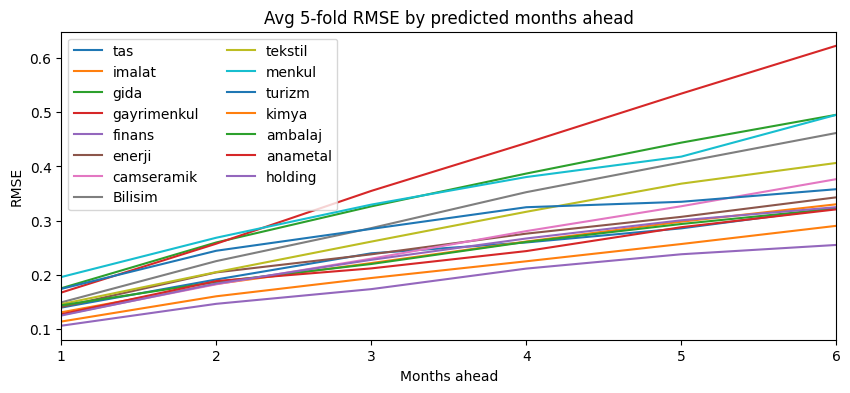

In [10]:
ax = plot_metric_by_months_sector(all_scores, 'RMSE')

In [11]:
save_scores(all_scores, 'model_scores/LR_pct_sector.json')

### SVR
Using the old sectoral division

In [12]:
from ProjectPackage.ModelClasses import SVRRegressorRBF

In [3]:
model_fit_params = dict(C=1, gamma=0.1, cv=5, fit_grid=False)

In [4]:
all_scores = run_sector_pct_model(
    SVRRegressorRBF,
    model_params={},
    model_fit_params=model_fit_params,
    month_range=range(1, 7),
    drop_corr_features=True,
    encoding_method='one-hot',
    drop=False,
    year_range=(2008, 2017),
)

C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, dummy_cols.columns] = dummy_cols.copy()
C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, dummy_cols.columns] = dummy_cols.copy()
C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting 

In [6]:
# save_scores(all_scores, 'model_scores/SVR_pct_sector.json')

### SVR
Using the new sectoral division

In [13]:
from ProjectPackage.ModelClasses import SVRRegressorRBF

In [2]:
model_fit_params = dict(C=1, gamma=0.1, cv=5, fit_grid=False)

In [15]:
all_scores = run_sector_pct_model(
    SVRRegressorRBF,
    model_params={},
    model_fit_params=model_fit_params,
    month_range=range(1, 7),
    drop_corr_features=True,
    encoding_method='one-hot',
    drop=False,
    year_range=(2008, 2017),
)

C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, dummy_cols.columns] = dummy_cols.copy()
C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, dummy_cols.columns] = dummy_cols.copy()
C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting 

### SVR
Using the new sectoral division and using the Yeo-Johnson transformation

In [5]:
from ProjectPackage.ModelClasses import SVRRegressorRBF

In [6]:
model_params = {'scaler': PowerTransformer()}
model_fit_params = dict(C=1, gamma=0.1, cv=5, fit_grid=False)

In [7]:
all_scores = run_sector_pct_model(
    SVRRegressorRBF,
    model_params=model_params,
    model_fit_params=model_fit_params,
    month_range=range(1, 7),
    drop_corr_features=True,
    encoding_method='one-hot',
    drop=False,
    year_range=(2008, 2017),
)

C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, dummy_cols.columns] = dummy_cols.copy()
C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, dummy_cols.columns] = dummy_cols.copy()
C:\Users\suuser\Desktop\Git\CS512-project\ProjectPackage\DataProcessing.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting 

In [8]:
# save_scores(all_scores, 'model_scores/SVR_pct_sector_johnson_transform.json')

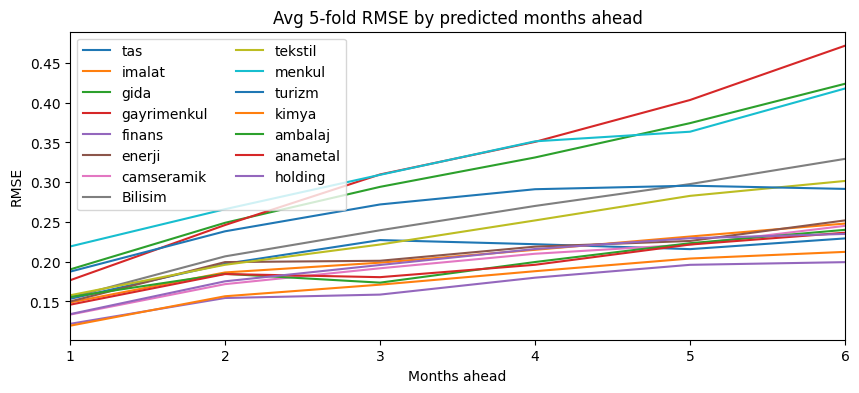

In [10]:
ax = plot_metric_by_months_sector(all_scores, 'RMSE')

Why R2 squared values are too high? [Read this](https://stats.stackexchange.com/questions/438847/r2-is-too-high-reasons)

In [23]:
lr_general_scores = load_scores('model_scores/LR_pct_general.json')
lr_sector_scores = load_scores('model_scores/LR_pct_sector.json')

svr_general_scores = load_scores('model_scores/SVR_pct_general.json')
svr_sector_scores = load_scores('model_scores/SVR_pct_sector.json')

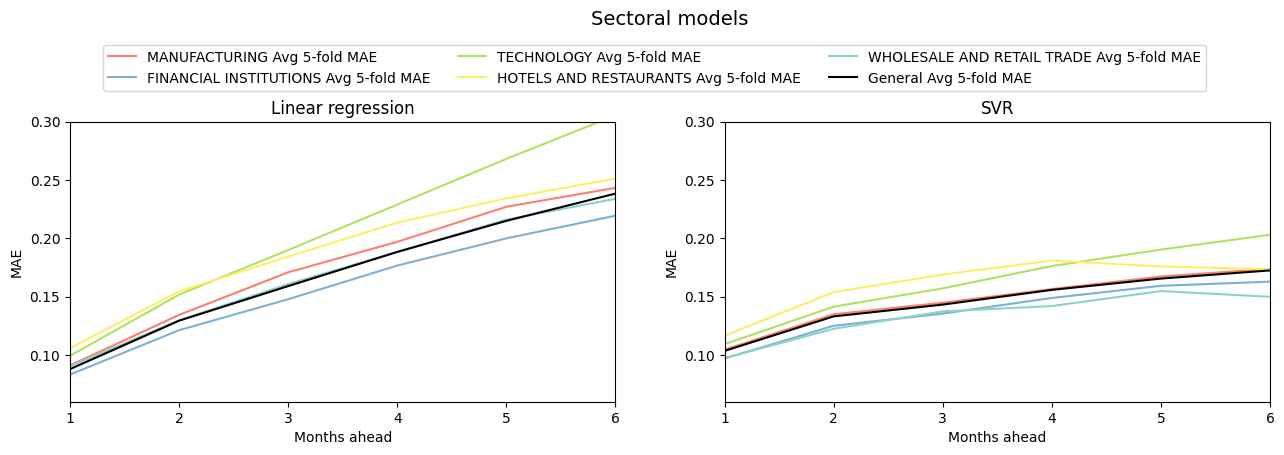

In [62]:
metric = 'MAE'

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax = axs[0]
plot_metric_by_months_sector(lr_sector_scores, metric, ax=ax)
plot_metric_by_months_general(lr_general_scores, metric, ax=ax, color='black', std=False)
ax.set_title('Linear regression')
legend = ax.legend()
ax.legend().remove()
ax.set_ylim(0.06, 0.3)

ax = axs[1]
plot_metric_by_months_sector(svr_sector_scores, metric, ax=ax)
plot_metric_by_months_general(svr_general_scores, metric, ax=ax, color='black', std=False)
ax.set_title('SVR')
ax.legend().remove()
ax.set_ylim(0.06, 0.3)

fig.subplots_adjust(left=0, bottom=0, right=1, top=0.7, wspace=0.2, hspace=0)
fig.legend(legend.legendHandles, map(lambda x: x.get_text(), legend.texts),
           ncols=3, loc=(0.08, 0.8))

fig.suptitle('Sectoral models', fontsize=14)
plt.show()

In [11]:
lr_general_scores = load_scores('model_scores/LR_pct_general.json')
lr_sector_scores = load_scores('model_scores/LR_pct_sector.json')

svr_general_scores = load_scores('model_scores/SVR_pct_general.json')
svr_sector_scores = load_scores('model_scores/SVR_pct_sector.json')

svr_sector_scores_johnson = load_scores('model_scores/SVR_pct_sector_johnson_transform.json')

In [2]:
lr_general_scores = load_scores('model_scores/LR_pct_general.json')
lr_sector_scores = load_scores('model_scores/LR_pct_sector.json')

svr_general_scores = load_scores('model_scores/SVR_pct_general.json')
svr_sector_scores = load_scores('model_scores/SVR_pct_sector.json')

rf_general_scores = load_scores('model_scores/RF_pct_general.json')
rf_sector_scores = load_scores('model_scores/RF_pct_sector.json')

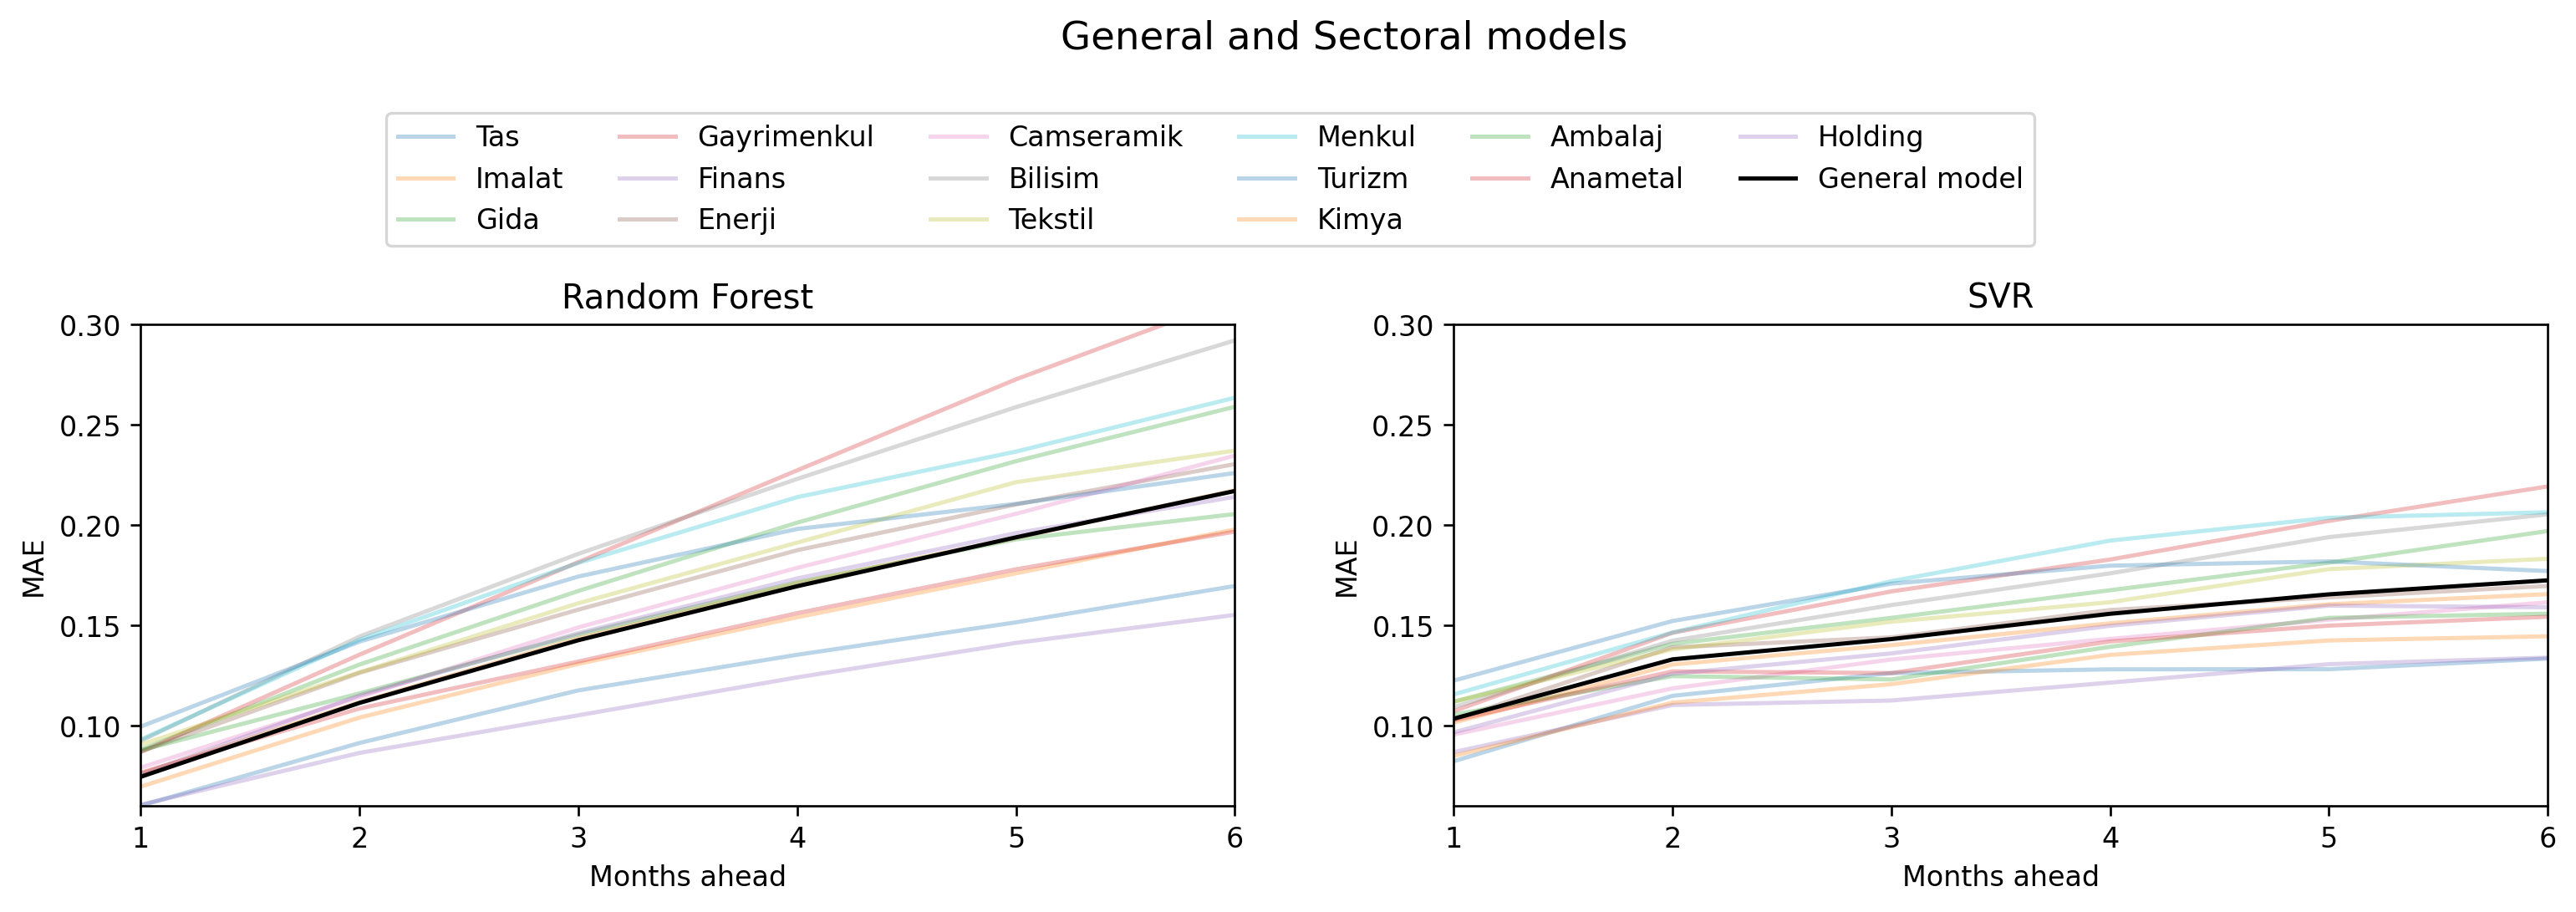

In [15]:
metric = 'MAE'

fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=240)
ax = axs[0]
plot_metric_by_months_sector(rf_sector_scores, metric, ax=ax, alpha=0.3)
plot_metric_by_months_general(rf_general_scores, metric, ax=ax, color='black', std=False)
ax.set_title('Random Forest')
legend = ax.legend()
ax.legend().remove()
ax.set_ylim(0.06, 0.3)

ax = axs[1]
plot_metric_by_months_sector(svr_sector_scores, metric, ax=ax, alpha=0.3)
plot_metric_by_months_general(svr_general_scores, metric, ax=ax, color='black', std=False)
ax.set_title('SVR')
ax.legend().remove()
ax.set_ylim(0.06, 0.3)

labels = list(map(lambda x: x.get_text().capitalize(), legend.texts))
labels[-1] = 'General model'
fig.subplots_adjust(left=0, bottom=0, right=1, top=0.6, wspace=0.2, hspace=0)
fig.legend(legend.legendHandles, labels,
           ncols=6, loc=(0.15, 0.73))

fig.suptitle('General and Sectoral models', fontsize=14)
plt.show()

## Random Forests

In [2]:
from ProjectPackage.ModelClasses import RFRegressor

In [7]:
model_fit_params = dict(n_estimators=[50, 100, 300],
            min_samples_leaf=[10, 20, 50],
            max_samples=[0.5, 0.75, 1],
            cv=5, fit_grid=True)

In [8]:
data_dict = load_data_sector(
    n_months=3, # Number of months ahead to be predicted
    pct_change=True, # Compute percentage change
    drop_corr_features=False, # Drop highly correlated features
    encoding_method='numeric', # Encoding method for tickers and sectors ("numeric", "one-hot", or None)
    drop=False, # Drop one of the one hot encoding columns to avoid multicollinearity
    year_range=(2008, 2017) # Range of years to be included (inclusive)
)

In [ ]:
param_dict = {}
for sector in data_dict.keys():
    X = data_dict[sector]['X']
    y = data_dict[sector]['y']
    
    model = RFRegressor()
    model.fit(X, y, **model_fit_params)
    
    param_dict[sector] = model.get_params()

In [13]:
# param_dict

{'tas': {'n_estimators': 100, 'min_samples_leaf': 20, 'max_samples': 0.75},
 'imalat': {'n_estimators': 300, 'min_samples_leaf': 20, 'max_samples': 0.5},
 'gida': {'n_estimators': 300, 'min_samples_leaf': 50, 'max_samples': 0.5},
 'gayrimenkul': {'n_estimators': 50,
  'min_samples_leaf': 20,
  'max_samples': 0.5},
 'finans': {'n_estimators': 300, 'min_samples_leaf': 20, 'max_samples': 0.5},
 'enerji': {'n_estimators': 50, 'min_samples_leaf': 10, 'max_samples': 0.5},
 'camseramik': {'n_estimators': 300,
  'min_samples_leaf': 10,
  'max_samples': 0.75},
 'Bilisim': {'n_estimators': 100, 'min_samples_leaf': 20, 'max_samples': 0.75},
 'tekstil': {'n_estimators': 100, 'min_samples_leaf': 10, 'max_samples': 0.5},
 'menkul': {'n_estimators': 100, 'min_samples_leaf': 50, 'max_samples': 0.5},
 'turizm': {'n_estimators': 100, 'min_samples_leaf': 10, 'max_samples': 0.75},
 'kimya': {'n_estimators': 100, 'min_samples_leaf': 10, 'max_samples': 0.5},
 'ambalaj': {'n_estimators': 100, 'min_samples_le

In [3]:
model_fit_params = dict(n_estimators=150,
            min_samples_leaf=15,
            max_samples=0.5,
            cv=5, fit_grid=False)

all_scores = run_sector_pct_model(
    RFRegressor,
    model_params={},
    model_fit_params=model_fit_params,
    month_range=range(1, 7),
    drop_corr_features=False,
    encoding_method='numeric',
    drop=False,
    year_range=(2008, 2017))

In [4]:
# save_scores(all_scores, 'model_scores/RF_pct_sector.json')

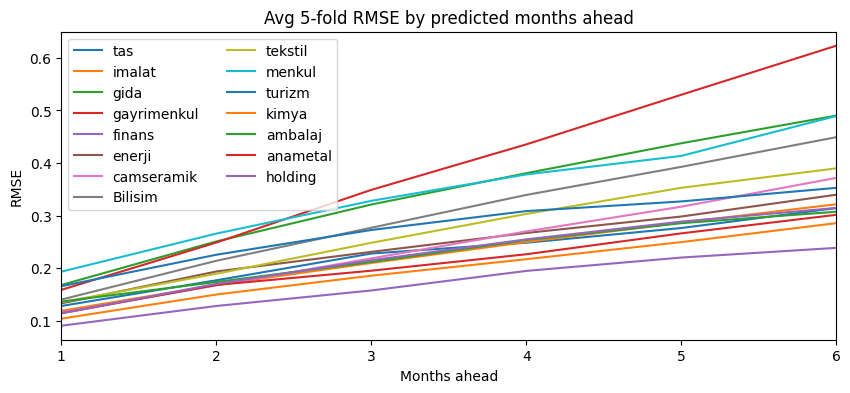

In [6]:
ax = plot_metric_by_months_sector(all_scores, 'RMSE')